In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot 
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [60]:
gamma = 1.4     #Гамма, она же каппа
#Различные формулы из гаммы
g_m_1_over_2g = (gamma-1)/2/gamma      #g1
g_p_1_over_2g = (gamma+1)/2/gamma      #g2
g_m_1_over_2g_inv = 1/g_m_1_over_2g    #g3
g_m_1_over_2_inv = 2/(gamma-1)         #g4
g_p_1_over_2_inv = 2/(gamma+1)         #g5
g_m_1_over_g_p_1 = (gamma-1)/(gamma+1) #g6
g_m_1_over_2 = (gamma-1)/2             #g7
g_m_1 = gamma-1  

tol = 1e-8

In [61]:

def sound_speed(W):
    d = W[0]
    p = W[2]
    return (gamma*(p/d))**0.5


In [62]:
def enthalpy(W):
    return 0.5*W[1]**2 + gamma/ g_m_1 *(W[2]/W[0])

In [63]:
def init(case):
    if case == 'sod':
        W_l = np.array([1, 0.75, 1])
        W_r = np.array([0.125, 0, 0.1])
        t = 0.25
    elif case == '123':
        W_l = np.array([1, -2, 0.4])
        W_r = np.array([1, 2, 0.4])
        t = 0.15
    elif case == 'left-woodward':
        W_l = np.array([1, 0, 1000])
        W_r = np.array([1, 0, 0.1])
        
        t = 0.012
    else : print('Unknown case!')
    return W_l, W_r, t

In [64]:
def U_to_W(U):
    W = np.zeros_like(U)
    W[0] = U[0]
    W[1] = U[1]/U[0]
    W[2] = g_m_1*(U[2] - 0.5*U[1]**2/U[0])
    return W


In [65]:
def W_to_U(W):
    U = np.zeros_like(W)
    U[0] = W[0]
    U[1] = W[1]*W[0]
    U[2] = 0.5*W[1]**2*W[0]+W[2]/ g_m_1
    return U


In [66]:
def flux(W):
    F = np.zeros_like(W)
    F[0] = W[1]*W[0]
    F[1] = W[1]**2*W[0] + W[2]
    F[2] = W[1]*(0.5*W[1]**2*W[0]+W[2]/ g_m_1 + W[2])
    return F

In [67]:

def roe_average(Wl,Wr):
    denom = Wl[0]**0.5 + Wr[0]**0.5
    u_tilda = (Wl[0]**0.5 * Wl[1] + Wr[0]**0.5 * Wr[1])/ denom
    H_tilda = (Wl[0]**0.5 * enthalpy(Wl) + Wr[0]**0.5 * enthalpy(Wr))/ denom
    a_tilda = (g_m_1*(H_tilda - 0.5*u_tilda**2))**0.5
    return u_tilda, H_tilda, a_tilda 




In [68]:
def roe_eigen_values(roe_average):
    lambdas = np.zeros(3)
    lambdas[0] = roe_average[0] - roe_average[2]
    lambdas[1] = roe_average[0] 
    lambdas[2] = roe_average[0] + roe_average[2]
    return lambdas

In [69]:
def roe_eigen_vectors(roe_average):
    K = np.zeros((3,3))
    K[0] = np.asarray([1, 
                       roe_average[0] - roe_average[2], 
                       roe_average[1] - roe_average[0] * roe_average[2] ])
    K[1] = np.asarray([1, 
                       roe_average[0] , 
                       0.5*roe_average[0] **2 ])
    K[2] = np.asarray([1, 
                       roe_average[0] + roe_average[2], 
                       roe_average[1] + roe_average[0] * roe_average[2] ])
    return K

In [70]:
def alfas(dU, roe_average):
    alfas = np.zeros(3)
    alfas[1] = g_m_1/roe_average[2]**2*(dU[0]*(roe_average[1] - roe_average[0]**2) + dU[1]*roe_average[0] - dU[2] )
    alfas[0] = 0.5/roe_average[2]*(dU[0]*(roe_average[0] + roe_average[2]) - dU[1] - roe_average[2]*alfas[1])
    alfas[2] = dU[0] - (alfas[0] +alfas[1])
    return alfas

In [71]:
def roe_flux(Wl,Wr):
    Fl,Fr = flux(Wl),flux(Wr)
    averages = roe_average(Wl,Wr)
    lambdas = roe_eigen_values(averages)
    K = roe_eigen_vectors(averages)
    alphas = alfas(W_to_U(Wr) - W_to_U(Wl), averages)
    roe_flux = 0.5*(Fl + Fr - np.dot(alphas*abs(lambdas),K))
    return roe_flux

In [72]:
N_points = 101
x = np.linspace(0,1,N_points)
decay_pos = 0.3
W_correct= np.zeros((N_points,3))

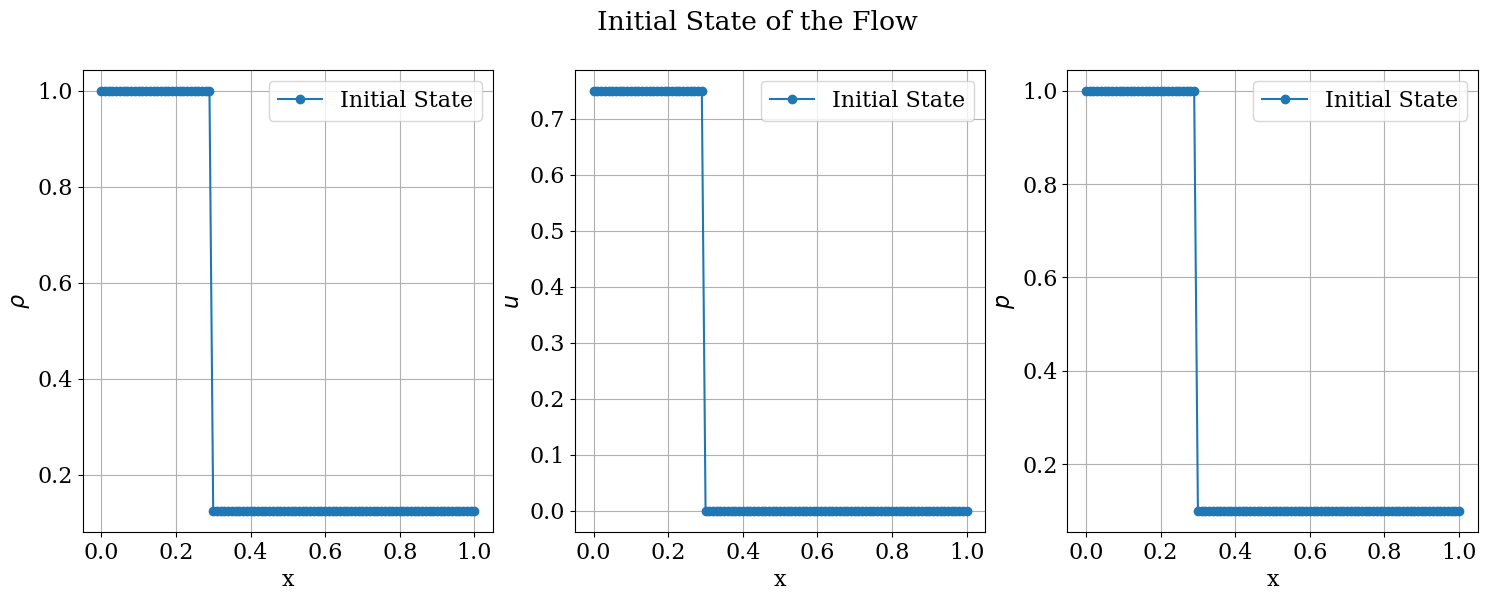

In [73]:

# Setup grid
N_points = 101
x = np.linspace(0, 1, N_points)
decay_pos = 0.3

# Initialize states
W_l, W_r, t = init('sod')
W = np.zeros((N_points, 3))
W[x < decay_pos, :] = W_l
W[x >= decay_pos, :] = W_r

# Plot the initial state
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, W_, y_label in zip(axs, W.T, (r'$\rho$', r'$u$', r'$p$')):
    ax.plot(x, W_, 'o-', label='Initial State')
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    ax.legend(loc='best')
    ax.grid()

plt.suptitle('Initial State of the Flow')
plt.show()


In [74]:
dx = 1./(N_points - 1)
sigma = 0.9

W = np.zeros((N_points,3))
fluxes = np.zeros((N_points - 1,3))
U = np.zeros_like(W) 

In [75]:
W_l,W_r,t = init('sod')
W[np.where(x<decay_pos),:] = W_l
W[np.where(x>=decay_pos),:] = W_r

In [76]:
t_ = 0
#dt = 0.0002
U_n = np.copy(U)
while t_<t:
    U = W_to_U(W.T).T
    roe_fluxes = np.zeros((N_points - 1,3))
    speeds = np.zeros(N_points - 1)
    for i,x_ in enumerate(x[:-1]):
        
        roe_fluxes[i] =roe_flux(W[i],W[i+1])
        c_l = sound_speed(W[i])
        c_r = sound_speed(W[i+1])
        speeds[i] = max(abs(W[i][1])+c_l,abs(W[i+1][1])+  c_r)

    
    dt = sigma*dx/max(speeds)
    U_n[1:-1,:] = U[1:-1,:] + dt/dx*(roe_fluxes[:-1,:]-roe_fluxes[1:,:]) 
    U_n[0,:] = U_n[1,:]
    U_n[-1,:] = U_n[-2,:]
    W = U_to_W(U_n.T).T
    t_=t_+dt

In [77]:
%store -r

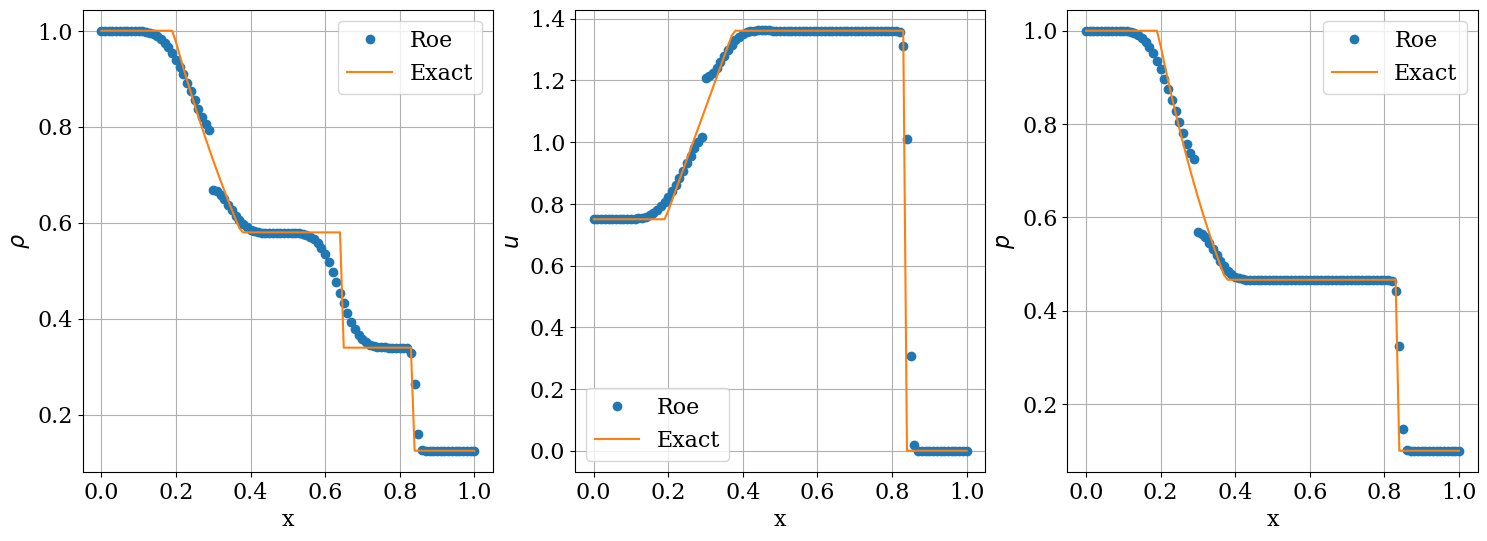

In [78]:
fig,axs = pyplot.subplots(1,3,figsize=(18,6) )

for ax, W_,  W_c, y_label in zip(axs, W.T,  W_correct.T, (r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x,W_,'o',label='Roe')
    #ax.plot(x,W_g_,'o',label='Godunov')
    ax.plot(x,W_c,label='Exact')
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    scale_y = 1.1*abs(max(W_c)-min(W_c))
    ax.set_ylim(0.5*(max(W_c)+min(W_c) - scale_y), 0.5*(max(W_c)+min(W_c) + scale_y))
    ax.legend(loc='best')
    ax.grid()
    plt.savefig('ROE1.png',dpi = 400)

In [79]:
W_roe = np.copy(W)
%store W_roe

Stored 'W_roe' (ndarray)


In [80]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot 
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [81]:
gamma = 1.4     #Гамма, она же каппа
#Различные формулы из гаммы
g_m_1_over_2g = (gamma-1)/2/gamma      #g1
g_p_1_over_2g = (gamma+1)/2/gamma      #g2
g_m_1_over_2g_inv = 1/g_m_1_over_2g    #g3
g_m_1_over_2_inv = 2/(gamma-1)         #g4
g_p_1_over_2_inv = 2/(gamma+1)         #g5
g_m_1_over_g_p_1 = (gamma-1)/(gamma+1) #g6
g_m_1_over_2 = (gamma-1)/2             #g7
g_m_1 = gamma-1  

tol = 1e-8

In [82]:
def sound_speed(d,p):
    return (gamma*(p/d))**0.5

In [83]:
def sound_speed_w(W):
    d = W[0]
    p = W[2]
    return sound_speed(d,p) 

In [84]:
def guess_p(W_l,W_r,label):
    c_l = sound_speed(W_l[0],W_l[2])
    c_r = sound_speed(W_r[0],W_r[2])

    
    W_aver = 0.5*(W_l+W_r)
    p_pv = W_aver[2] - 0.5*(W_r[1]-W_l[1])*W_aver[0]*0.5*(c_l+c_r)
    p_0 = max(tol,p_pv)
    
    if label == 'TR':
        return ((c_l + c_r - 0.5*g_m_1*(W_r[1] - W_l[1]))/
                ((c_l/W_l[2]**g_m_1_over_2g) + (c_r/W_r[2]**g_m_1_over_2g) ))**g_m_1_over_2g_inv
    
    elif label == 'PV':

        return p_0
    
    elif label == 'TS':
        A_k = lambda x : g_p_1_over_2_inv/x
        B_k = lambda x : g_m_1_over_g_p_1*x
        p_ts = ((A_k(W_l[0])/(p_pv + B_k(W_l[2])))**0.5*W_l[2] + (A_k(W_r[0])/(p_pv + B_k(W_r[2])))**0.5*W_r[2] \
                - (W_r[1]-W_l[1])) /\
        ((A_k(W_l[0])/(p_pv + B_k(W_l[2])))**0.5 + (A_k(W_r[0])/(p_pv + B_k(W_r[2])))**0.5)  
        return max(tol,p_ts)
    else:
        return W_aver[2]
        

In [85]:
def init(case):
    if case == 'sod':
        W_l = np.array([1, 0.75, 1])
        W_r = np.array([0.125, 0, 0.1])
        t = 0.25
    elif case == '123':
        W_l = np.array([1, -2, 0.4])
        W_r = np.array([1, 2, 0.4])
        t = 0.15
    elif case == 'left-woodward':
        W_l = np.array([1, 0, 1000])
        W_r = np.array([1, 0, 0.1])
        
        t = 0.012
    else : print('Unknown case!')
    return W_l, W_r, t

In [86]:
W_l,W_r,_ = init('sod')

In [87]:
def U_to_W(U):
    W = np.zeros_like(U)
    W[0] = U[0]
    W[1] = U[1]/U[0]
    W[2] = g_m_1*(U[2] - 0.5*U[1]**2/U[0])
    return W

In [88]:
def W_to_U(W):
    U = np.zeros_like(W)
    U[0] = W[0]
    U[1] = W[1]*W[0]
    U[2] = 0.5*W[1]**2*W[0]+W[2]/ g_m_1
    return U

In [89]:
def flux(W):
    F = np.zeros_like(W)
    F[0] = W[1]*W[0]
    F[1] = W[1]**2*W[0] + W[2]
    F[2] = W[1]*(0.5*W[1]**2*W[0]+W[2]/ g_m_1 + W[2])
    return F

In [90]:
def q(p,p_star):
    if p_star > p:
        return (1 + g_p_1_over_2g*(p_star/p - 1))**0.5
    else :
        return 1

In [91]:
def get_speeds(W_l,W_r,p_star):
    S_l = W_l[1] - sound_speed_w(W_l)*q(W_l[2],p_star)
    S_r = W_r[1] + sound_speed_w(W_r)*q(W_r[2],p_star)
    
    S_star = (W_r[2] - W_l[2] + \
              W_l[0]*W_l[1]*(S_l - W_l[1]) - \
              W_r[0]*W_r[1]*(S_r - W_r[1]))/( W_l[0]*(S_l - W_l[1]) - \
              W_r[0]*(S_r - W_r[1]) )
    return np.asarray((S_l,S_r,S_star))


In [92]:
def F_HLLC(W,S_star,S):
    D = np.asarray([0,1,S_star])
    F_star = (S_star*(S*W_to_U(W) - flux(W)) + \
              S*(W[2] + W[0]*(S - W[1])*(S_star - W[1]))*D)/\
    (S - S_star)
    return F_star

In [93]:
def hllc_flux(W_l,W_r):
    p_star = guess_p(W_l,W_r,'TR')
    S_l,S_r,S_star = get_speeds(W_l,W_r,p_star)
    if 0 <= S_l:
        return flux(W_l)
    if S_l <= 0 <= S_star:
        return F_HLLC(W_l,S_star,S_l)
    if S_star <= 0 <= S_r:
        return F_HLLC(W_r,S_star,S_r)
    if 0 >= S_r:
        return flux(W_r)

In [94]:
N_points = 101
x = np.linspace(0,1,N_points)
decay_pos = 0.3
W_correct= np.zeros((N_points,3))

In [95]:
W_l,W_r,t = init('sod')


In [96]:
dx = 1./(N_points - 1)
sigma = 0.9

W = np.zeros((N_points,3))
fluxes = np.zeros((N_points - 1,3))
U = np.zeros_like(W) 

In [97]:
W[np.where(x<decay_pos),:] = W_l
W[np.where(x>=decay_pos),:] = W_r

In [98]:
t_ = 0
#dt = 0.0002
U_n = np.copy(U)
while t_<t:
    U = W_to_U(W.T).T
    hllc_fluxes = np.zeros((N_points - 1,3))
    speeds = np.zeros(N_points - 1)
    for i,x_ in enumerate(x[:-1]):
        
        hllc_fluxes[i] =hllc_flux(W[i],W[i+1])
        c_l = sound_speed(W[i][0],W[i][2])
        c_r = sound_speed(W[i+1][0],W[i+1][2])
        speeds[i] = max(abs(W[i][1])+c_l,abs(W[i+1][1])+  c_r)

    
    dt = sigma*dx/max(speeds)
    U_n[1:-1,:] = U[1:-1,:] + dt/dx*(hllc_fluxes[:-1,:]-hllc_fluxes[1:,:]) 
    U_n[0,:] = U_n[1,:]
    U_n[-1,:] = U_n[-2,:]
    W = U_to_W(U_n.T).T
    t_=t_+dt

In [99]:
%store -r

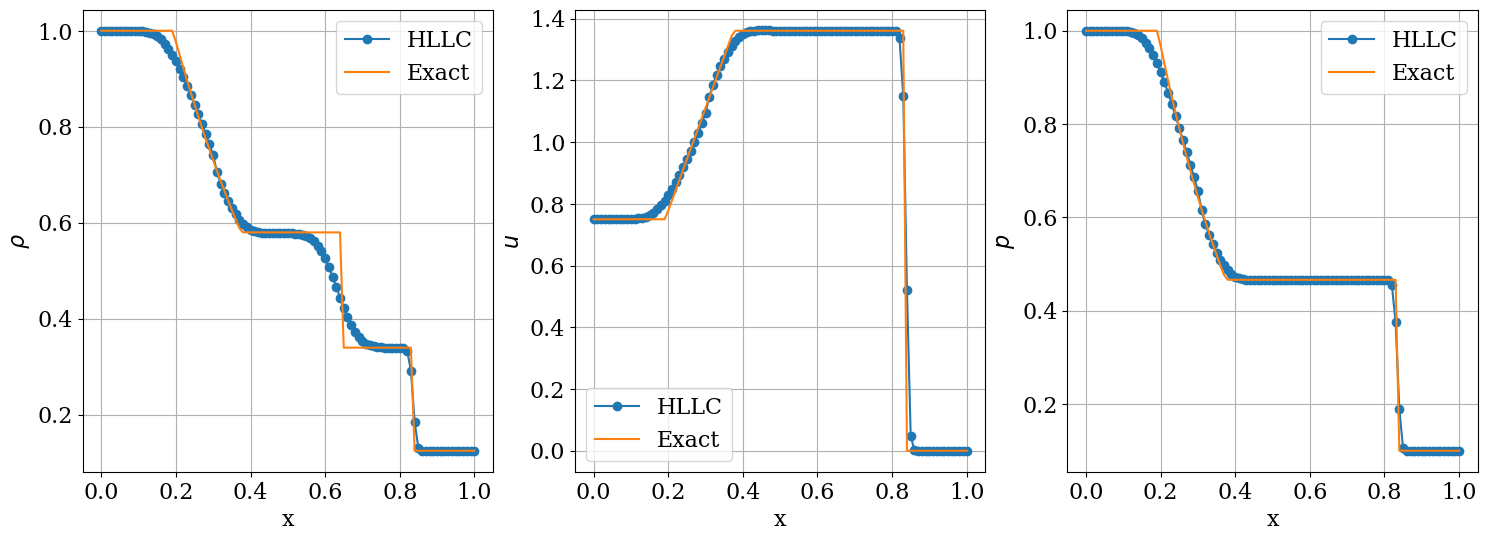

In [100]:
fig,axs = pyplot.subplots(1,3,figsize=(18,6)
                         )
for ax, W_, W_r_, W_c, y_label in zip(axs, W.T, W_roe.T, W_correct.T, (r'$\rho$',r'$u$',r'$p$') ):
#for ax, W_,  W_c, y_label in zip(axs, W.T,  W_correct.T, (r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x,W_,'o-',label='HLLC')
    #ax.plot(x,W_r_,'o',label='Roe')
    ax.plot(x,W_c,label='Exact')
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    scale_y = 1.1*abs(max(W_c)-min(W_c))
    ax.set_ylim(0.5*(max(W_c)+min(W_c) - scale_y), 0.5*(max(W_c)+min(W_c) + scale_y))
    ax.legend(loc='best')
    ax.grid()
    #plt.savefig('HLLC.png',dpi = 400)

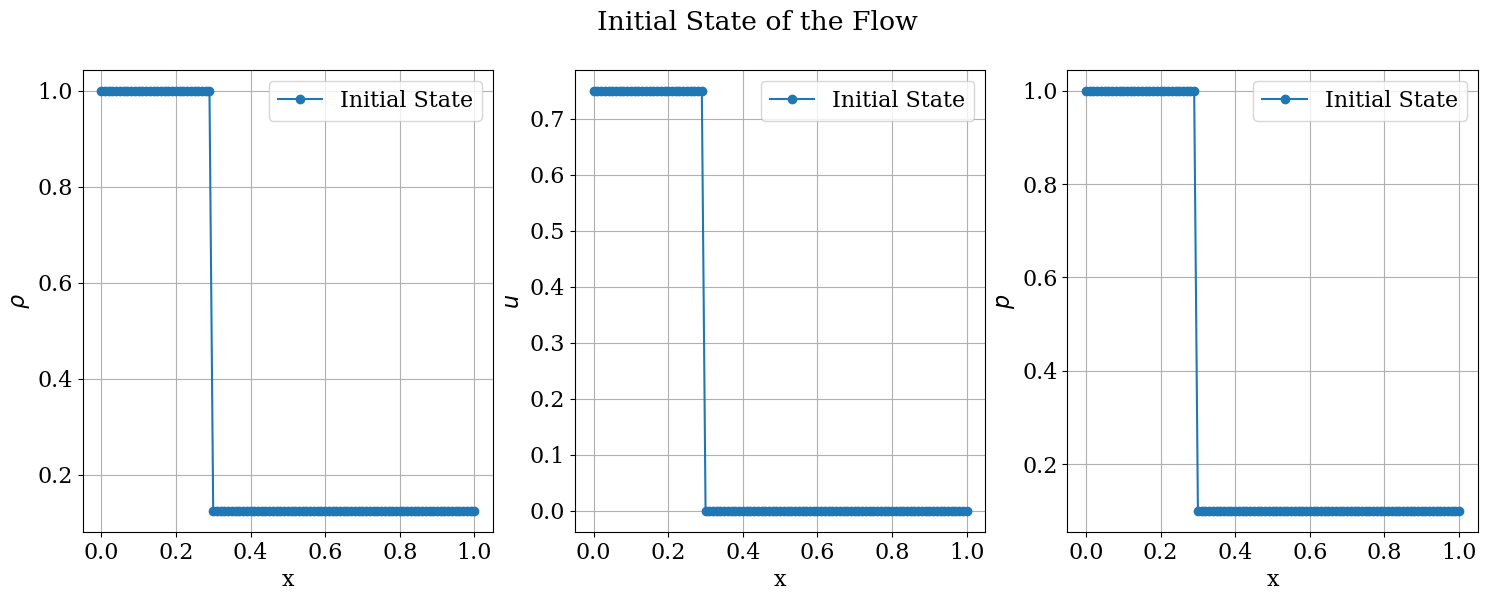

In [101]:
# Setup grid
N_points = 101
x = np.linspace(0, 1, N_points)
decay_pos = 0.3

# Initialize states
W_l, W_r, t = init('sod')
W = np.zeros((N_points, 3))
W[x < decay_pos, :] = W_l
W[x >= decay_pos, :] = W_r

# Plot the initial state
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, W_, y_label in zip(axs, W.T, (r'$\rho$', r'$u$', r'$p$')):
    ax.plot(x, W_, 'o-', label='Initial State')
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    ax.legend(loc='best')
    ax.grid()

plt.suptitle('Initial State of the Flow')
plt.show()